# Introduction to Neural Force Field

This Jupyter Notebook contains an introduction to the `nff` package. Here, we will load the modules and functions from `nff` to import a dataset, create dataloaders, create a model, train it and check the test stats. We will do most of it manually to illustrate the usage of the API. However, scripts such as the one provided in the `scripts/` folder already automate most of this process.

After the `nff` package has been installed, we start by importing all dependencies for this tutorial.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve


import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import (Dataset, split_train_validation_test, 
                      collate_dicts, to_tensor, ImbalancedDatasetSampler)
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

from nff.hypopt.data import trim_confs

It might also be useful setting the GPU you want to use:

In [22]:
import random

import os
base_pth = "/home/saxelrod/engaging_nfs/data_from_fock/data/covid_data/"

# main_pth = os.path.join(base_pth, "covid_mmff94_1_voxels.pth.tar")

# main_pth = os.path.join(base_pth, "covid_mmff94_1_voxels_channels.pth.tar")

main_pth = os.path.join(base_pth, "all_crest_voxels.pth.tar")



# suffixes = ["all_crest_voxels_train.pth.tar", "all_crest_voxels_val.pth.tar", 
#        "all_crest_voxels_test.pth.tar"]


# suffixes = ["covid_mmff94_1_voxels_train.pth.tar", "covid_mmff94_1_voxels_val.pth.tar", 
#        "covid_mmff94_1_voxels_test.pth.tar"]

suffixes = ["covid_mmff94_1_voxels_train_channels.pth.tar", 
            "covid_mmff94_1_voxels_val_channels.pth.tar", 
            "covid_mmff94_1_voxels_test_channels.pth.tar"]

pths = [os.path.join(base_pth, suffix) for suffix in suffixes]



# if all([os.path.isfile(file) for file in pths]):
#     print("Loading from file...")
#     train, val, test = [Dataset.from_file(pth) for pth in pths]
#     print("Loaded from file.")
# else:

print("Loading dataset...")
dataset = Dataset.from_file(main_pth)
# dataset.add_morgan(1000)


# dataset.props["voxel"] = dataset.props["fingerprint"] 
# dataset.props.pop("fingerprint")

# bind_idx = dataset.props['bind'].nonzero()
# rand_idx = [i for i in list(range(len(dataset))) if i not in bind_idx]
# rand_idx = random.sample(rand_idx, 5000)
# all_idx = rand_idx + bind_idx.reshape(-1).tolist()
# new_props = {}
# for key, val in dataset.props.items():
#     if type(val) is list:
#         new_props[key] = [val[i] for i in all_idx]
#     else:
#         new_props[key] = val[all_idx]

# new_dataset = Dataset(props=new_props, units=dataset.units)

# train, val, test = split_train_validation_test(new_dataset, binary=True, targ_name='bind')

print("Splitting...")
train, val, test = split_train_validation_test(dataset, binary=True, targ_name='bind')
print("Saving...")
for pth, dset in zip(pths, [train, val, test]):
    dset.save(pth)

# del dataset


Loading dataset...
Splitting...
Saving...


In [23]:
import json

bind_idx = dataset.props['bind'].nonzero()
bind_smiles = [dataset.props['smiles'][i] for i in bind_idx]
with open("bind_smiles.json", "w") as f:
        json.dump(bind_smiles, f)

In [4]:
DEVICE = 0
BATCH_SIZE = 50
MINI_BATCHES = int(50 / BATCH_SIZE)

OUTDIR = './sandbox'

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)

Create loaders:

In [5]:
loaders = []

for split in [train, val, test]:
    props = split.props
    kwargs = {}
    if split in [train]:
        sampler = ImbalancedDatasetSampler(
            target_name="bind",
            props=props)
        kwargs.update({"sampler": sampler})
    loader = DataLoader(split, batch_size=BATCH_SIZE, 
                        collate_fn=collate_dicts,
                       **kwargs)
    loaders.append(loader)
    
train_loader, val_loader, test_loader = loaders

In [6]:
import pdb

num_bind = 0
num_non_bind = 0

for batch in train_loader:
    bind = batch['bind'].sum()
    non_bind = len(batch['bind']) - bind

    num_bind += bind.item()
    num_non_bind += non_bind.item()

print(num_bind)
print(num_non_bind)
print(num_bind / (num_bind + num_non_bind))


1776
1737
0.5055508112724167


`nff` is based on SchNet. It parameterizes interatomic interactions in molecules and materials through a series of convolution layers with continuous filters. Here, we are going to create a simple model using the hyperparameters given on `params`:

In [7]:
for dset in [train, val, test]:
    dset.props['fingerprint'] = dset.props['voxel']

In [8]:
 next(iter(train_loader))["atom_features"].shape

torch.Size([20845, 134])

In [9]:
next(iter(train_loader))["atom_features"].shape[-1]

134

In [10]:

# morgan_len = 1000
# n_mol_basis  = train.props['fingerprint'][0].shape[0] + morgan_len
n_mol_basis  = train.props['fingerprint'][0].shape[0] 



n_atom_basis = 1
n_bond_features = 1

n_bond_hidden = 300

n_filters = 30

n_gaussians = 10
n_edge_hidden = n_bond_hidden + n_filters


mol_fp_drop = 0.0
schnet_dropout = 0.5
cp_dropout = 0.0
readout_drop = 0.2
n_convolutions = 2


input_layers = [{'name': 'linear', 'param': {'in_features': n_bond_features + n_atom_basis,
                                         'out_features': n_bond_hidden}},
            {'name': 'ReLU', 'param': {}}]

output_layers = [{'name': 'linear', 'param': {'in_features': n_atom_basis + n_edge_hidden,
                                         'out_features': n_mol_basis}},
                {'name': 'ReLU', 'param': {}}]

readoutdict = {'bind': [
            {'name': 'linear', 'param' : { 'in_features': n_mol_basis, 'out_features': int(n_mol_basis / 2)}},
            {'name': 'ReLU', 'param': {}},
            {'name': 'Dropout', 'param': {'p': readout_drop}},
            {'name': 'linear', 'param' : { 'in_features': int(n_mol_basis / 2), 'out_features': 1}},
            {'name': 'sigmoid', 'param': {}},
        ]
    }


mol_fp_layers = []



params = {
    'n_atom_basis': n_atom_basis,
    'n_bond_hidden': n_bond_hidden,
    'input_layers': input_layers,
    'output_layers': output_layers,
    'n_filters': n_filters,
    'n_gaussians': n_gaussians,
    'cp_dropout': cp_dropout,
    'schnet_dropout': schnet_dropout,
    'gauss_embed': True,
    'n_convolutions': n_convolutions,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'dropout_rate': schnet_dropout,
    'readoutdict': readoutdict,
    'boltzmann_dict': {'type': 'multiply'},
    'mol_fp_layers': mol_fp_layers,
    'same_filters': True,
    'activation': 'ReLU',
    'batch_embeddings': True,
#     "extra_features": [{"name": "morgan", "length": 1000}]
#     "extra_features": [{"name": "morgan", "length": 1000}]


    
}



model = get_model(params, model_type="SchNetFeatures")

In [11]:
# delattr(model, "convolutions")
# delattr(model, "mol_fp_nn")
# delattr(model, "W_i")
# delattr(model, "W_o")

## Creating a trainer

In [12]:
model

SchNetFeatures(
  (convolutions): ModuleList(
    (0): CpSchNetConv(
      (dense): Dense(
        in_features=300, out_features=300, bias=False
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (activation): ReLU()
      (moduledict): ModuleDict(
        (edge_filter): Sequential(
          (0): GaussianSmearing()
          (1): Dense(
            in_features=10, out_features=30, bias=True
            (dropout): Dropout(p=0.5, inplace=False)
          )
          (2): ReLU()
        )
      )
    )
    (1): CpSchNetConv(
      (dense): Dense(
        in_features=300, out_features=300, bias=False
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (activation): ReLU()
      (moduledict): ModuleDict(
        (edge_filter): Sequential(
          (0): GaussianSmearing()
          (1): Dense(
            in_features=10, out_features=30, bias=True
            (dropout): Dropout(p=0.5, inplace=False)
          )
          (2): ReLU()
        )
      )
    )
  )
  (mol

To train our model with the data provided, we have to create a loss function. The easiest way to do that is through the `build_mse_loss` builder. Its argument `rho` is a parameter that will multiply the mean square error (MSE) of the force components before summing it with the MSE of the energy.

In [13]:
loss_fn = loss.build_cross_entropy_loss(loss_coef={'bind': 1})

We should also select an optimizer for our recently created model:

In [14]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

### Metrics and hooks

If we want to monitor the progress of our training, say by looking at the mean absolute error (MAE) of energies and forces, we can simply create metrics to observe them:

In [15]:
train_metrics = [
    metrics.RocAuc('bind'),
    metrics.PrAuc('bind')
]

Furthermore, if we want to customize how our training procedure is done, we can use hooks which can interrupt or change the train automatically.

In our case, we are adding hooks to:
* Stop the training procedure after 100 epochs;
* Log the training on a machine-readable CSV file under the directory `./sandbox`;
* Print the progress on the screen with custom formatting; and
* Setup a scheduler for the learning rate.

In [16]:
train_hooks = [
    hooks.MaxEpochHook(1000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=10,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

A `Trainer` in the `nff` package is a wrapper to train a model. It automatically creates checkpoints, as well as trains and validates a given model. It also allow further training by loading checkpoints from existing paths, making the training procedure more flexible. Its functionalities can be extended by the hooks we created above. To create a trainer, we have to execute the following command:

In [17]:
T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_intbatcerval=1,
    hooks=train_hooks,
    mini_batches=MINI_BATCHES
)

Now we can finally train the model using the method `train` from the `Trainer`:

In [18]:
import pdb

try:
    T.train(device=DEVICE, n_epochs=1000)
except Exception as e:
    print(e)
    pdb.post_mortem()

 Time | Epoch | Learning rate | Train loss | Validation loss | RocAuc_bind | PrAuc_bind | GPU Memory (MB)
48:28 |     1 |     1.000e-04 |     0.7092 |          0.5684 |      0.4392 |     0.0572 |             171
48:29 |     2 |     1.000e-04 |     0.6941 |          0.7196 |      0.5486 |     0.0836 |             171
48:30 |     3 |     1.000e-04 |     0.6772 |          0.7101 |      0.5301 |     0.0767 |             172
48:31 |     4 |     1.000e-04 |     0.6740 |          0.7050 |      0.5131 |     0.0740 |             172
48:32 |     5 |     1.000e-04 |     0.6751 |          0.6627 |      0.4836 |     0.0725 |             172
48:33 |     6 |     1.000e-04 |     0.6679 |          0.7854 |      0.5570 |     0.0799 |             172
48:34 |     7 |     1.000e-04 |     0.6679 |          0.8075 |      0.5518 |     0.0826 |             172
48:36 |     8 |     1.000e-04 |     0.6608 |          0.7514 |      0.5432 |     0.0772 |             172
48:37 |     9 |     1.000e-04 |     0.6595 |  

49:56 |    78 |     1.250e-05 |     0.4838 |          0.6150 |      0.5667 |     0.1061 |             172
49:57 |    79 |     6.250e-06 |     0.4813 |          0.5767 |      0.5590 |     0.1025 |             172
49:58 |    80 |     6.250e-06 |     0.4754 |          0.6056 |      0.5608 |     0.1020 |             172
49:59 |    81 |     6.250e-06 |     0.4824 |          0.5631 |      0.5532 |     0.1003 |             172
50:00 |    82 |     6.250e-06 |     0.4739 |          0.6175 |      0.5590 |     0.1000 |             172
50:01 |    83 |     6.250e-06 |     0.4672 |          0.6025 |      0.5592 |     0.1014 |             172
50:02 |    84 |     6.250e-06 |     0.4613 |          0.5992 |      0.5593 |     0.1025 |             172
50:04 |    85 |     6.250e-06 |     0.4729 |          0.5687 |      0.5517 |     0.0990 |             172
50:05 |    86 |     6.250e-06 |     0.4760 |          0.5853 |      0.5545 |     0.1007 |             172
50:06 |    87 |     6.250e-06 |     0.4824 |  

## Evaluating the model on the test set

Now we have a brand new model trained and validated. We can use the best model from this training to evaluate its performance on the test set. `results` contains the predictions of properties for the whole test dataset. `targets` contains the ground truth for such data. `test_loss` is the loss, calculated with the same function used during the training part

In [19]:
sampler = ImbalancedDatasetSampler(
    target_name="bind",
    props=props)

balanced_test_loader = DataLoader(test, batch_size=BATCH_SIZE, 
            collate_fn=collate_dicts,
           sampler=sampler)

results, targets, val_loss = evaluate(model, balanced_test_loader, loss_fn, device=DEVICE)


In [20]:
y_score = torch.cat(results['bind']).reshape(-1).numpy()
y_true = torch.cat(targets['bind']).reshape(-1).numpy()

roc_score = roc_auc_score(y_true=y_true, y_score=y_score)
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
prc_score = auc(recall, precision)



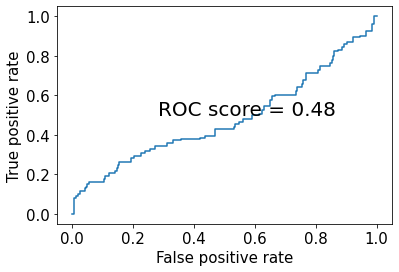

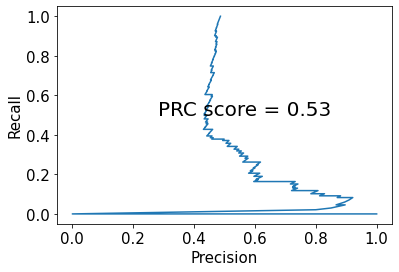

In [21]:
plt.rcParams.update({'font.size': 15})


text = "ROC score = %.2f" % roc_score

fig, ax = plt.subplots()
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.3, 0.5, text, fontsize=20, transform=ax.transAxes)

plt.show()




text = "PRC score = %.2f" % prc_score

fig, ax = plt.subplots()
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.text(0.3, 0.5, text, fontsize=20, transform=ax.transAxes)


plt.show()